# Image Fraud Detection Algorithm Analysis

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.preprocessing import image

DIR = os.getcwd()
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_PIXELS = IMG_HEIGHT*IMG_WIDTH
COLOR_MODE = 'grayscale'
PATH_DATASET_TRAIN = "Datasets/dataset_train/"

2022-05-18 19:40:03.751768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 19:40:03.751786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
plt.rcParams['figure.figsize'] = (15,12)

## Data Loading

Loading a total of 40000 images with 28x28 pixels and grayscale as the color mode. The division is as the following:

- 20000 real images
- 20000 fake images


In [6]:
def loadDataset():
    train_ds = image_dataset_from_directory(
        PATH_DATASET_TRAIN,
        labels = 'inferred',
        label_mode='binary',
        color_mode=COLOR_MODE,
        image_size=(IMG_HEIGHT,IMG_WIDTH)
    )

    return train_ds.unbatch()
train_ds = loadDataset()

Found 40000 files belonging to 2 classes.


2022-05-18 19:40:07.730430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 19:40:07.731032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 19:40:07.731084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-18 19:40:07.731130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-18 19:40:07.731175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [7]:
def formatDataset(dataset):
    X = []
    Y = []
    for img,label in dataset.as_numpy_iterator():
        imgData = np.array([row.flatten() for row in img])
        X.append(imgData.flatten())
        Y.append(label[0])
    X = np.array(X)
    Y = np.array(Y)
    return X/255,Y

We use the tensorflow library to get the data and then use the function formatDataset to return numpy arrays to use for the models training:

- Returns a numpy array with shape (40000,28,28) 
    - 40000 rows equals the 40000 images
    - Inside each row is the information of the image after being loaded
- Also returns another numpy array with shape (40000,1), which the label corresponding to each image
    - Label 0 --> **FAKE**
    - Label 1 --> **REAL**

# **Data Dimension Reduction**

### Principal Component Analysis

- Linear dimensionality reduction technique for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space.
- Speeds up your machine learning algorithm's training and testing time considering your data has a lot of features, and the ML algorithm's learning is too slow.

In [8]:
from sklearn.decomposition import PCA

In [9]:
X,Y = formatDataset(train_ds)
totImages = Y.shape[0]

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
print('Explained Variance Ratio',sum(pca.explained_variance_ratio_))


Explained Variance Ratio 0.9138805486727506


# Data Splitting

## Train - Validation/Test

In this case the validation Ratio is according to the rest of the first split

Example: 
    - valRatio = 0.5; testRatio = 0.4
    - Then 0.5*0.4 = 0.2 so in reality the validation ratio is 20%

In [10]:
def TVT(X,Y,testRatio,valRatio):
    X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=valRatio, random_state=13)
    return X_train,X_val,X_test,Y_train,Y_val,Y_test

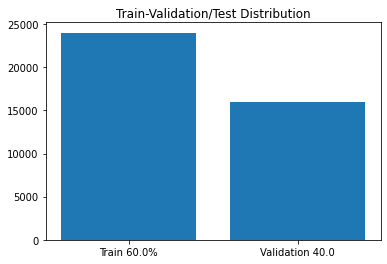

In [11]:
#X_train,X_val,X_test,Y_train,Y_val,Y_test = TVT(X,Y,0.4,0.5)
X_train, X_val, Y_train, Y_val = train_test_split(X_pca, Y, test_size=0.4, random_state=13)
freqs = [Y_train.shape[0],Y_val.shape[0]]

plt.bar([f'Train {(freqs[0]/totImages)*100}%',f'Validation {freqs[1]/totImages*100}'],freqs)
plt.title('Train-Validation/Test Distribution')
plt.show()

# **Models Prediction Analysis**

### Support Vector Macinhe (SVM)

- SVM's are algorithms commonly used for supervised machine learning models. 
- High degree of accuracy compared to other classification algorithms such as **K-Nearest Neighbour**
- Separate data into different classes of data by using a hyperplane, supported by the use of **support vectors**
- **Kernel** function transforms the data into a higher dimension
    - Example: <u>Negative sum of the squares</u> of the coordinates for each of these values and have that equal the third dimension of the data
- **Paramter Testing**:
    - Kernel
    - C = Regularization parameter
    - 

Implementation Code docs: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
### Artificial Neural Networks (MLP)
- Capable of learning any <u>non-linear</u> function
- Cannot capture sequential information in the input data which is required for dealing with sequence data
- Consists of 3 layers – Input, Hidden and Output
- The architeture is called Multi Layer Perceptron(MLP) a group of multiple perceptrons/neurons at each layer
- Solve problems related to: Tabular data, Image data and Text data
- **Paramter Testing**:
    - Learning Rate
    - Activation function

Implementation Code docs: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

Now, let us see how to overcome the limitations of MLP usinng the architecture of Convolution Neural Networks (CNN). 
Recurrent Neural Networks (RNN) will not be used in this project

### Convulotinary Neural Networks(CNN):
- Building blocks of CNNs are filters a.k.a. kernels, that are used to extract the relevant features from the input using the convolution operation.
- Learns the filters automatically without mentioning it explicitly. These filters help in extracting the right and relevant features from the input data
- Captures the spatial features from an image. Spatial features refer to the arrangement of pixels and the relationship between them in an image.
- Also follows the concept of parameter sharing. A single filter is applied across different parts of an input to produce a feature map
- **Paramter Testing**:
    


In [13]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import GridSearchCV
import pandas as pd

metrics = ['precision','recall','accuracy','roc_auc']
columns = ['mean_test_accuracy','std_test_accuracy','mean_test_precision','std_test_precision','mean_test_recall','std_test_recall','mean_test_roc_auc','std_test_roc_auc']

def modelMetricsParams(name,model):
    sets_model = {}
    df = pd.DataFrame(columns = columns)
    modelResults = model.cv_results_
    setParams = modelResults['params']
    for i in range(len(setParams)):
        row = []
        for col in columns:
            row.append(modelResults[col][i])
        indexModel = f'{name}{i+1}'
        df.loc[indexModel] = row
        sets_model.update({indexModel:setParams[i]})
    return df,sets_model

### Evaluation Metrics:
- Accuracy:
- Precision:
- Recall:
- ROC_AUC:

In [10]:
#C = 0.01,0.1,10
params_SVM = {'kernel':['linear','poly','rbf']}

svmModel = GridSearchCV(SVC(),params_SVM,scoring = metrics,refit = False)

print(X_train.shape)
svmModel.fit(X_train,Y_train)
df_SVM,sets_SVM = modelMetricsParams('SVM',svmModel)

In [ ]:
df_SVM

,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc
SVM1,0.717792,0.006732,0.724652,0.005689,0.702765,0.009963,0.780765,0.006703
SVM2,0.921917,0.003863,0.925993,0.002863,0.917194,0.007148,0.973691,0.002119
SVM3,0.924417,0.003150,0.925750,0.005194,0.922943,0.003767,0.976747,0.001201
SVM4,0.509875,0.029751,0.509884,0.029540,0.513909,0.031237,0.516332,0.039273


: 

: 

: 

: 

: 

: 

: 

In [ ]:
best_recall_svm = max(df_SVM['mean_test_recall'])
svm_name = df_SVM['mean_test_recall'].idxmax()

print(f'Best recall: {best_recall_svm}\nModel {svm_name} with the parameters: {sets_SVM[svm_name]}\n')

best_precision_svm = max(df_SVM['mean_test_precision'])
svm_name = df_SVM['mean_test_precision'].idxmax()
print(f'Best precision: {best_precision_svm}\nModel {svm_name} with the parameters: {sets_SVM[svm_name]}\n')

best_accuracy_svm = max(df_SVM['mean_test_accuracy'])
svm_name = df_SVM['mean_test_accuracy'].idxmax()
print(f'Best accuracy: {best_accuracy_svm}\nModel {svm_name} with the parameters: {sets_SVM[svm_name]}\n')

best_roc_auc_svm = max(df_SVM['mean_test_roc_auc'])
svm_name = df_SVM['mean_test_roc_auc'].idxmax()
print(f'Best ROC_AUC: {best_roc_auc_svm}\nModel {svm_name} with the parameters: {sets_SVM[svm_name]}\n')

Best recall: 0.9229425933638762
Model SVM3 with the parameters: {'kernel': 'rbf'}

Best precision: 0.9259931003952444
Model SVM2 with the parameters: {'kernel': 'poly'}

Best precision: 0.9244166666666669
Model SVM3 with the parameters: {'kernel': 'rbf'}

Best precision: 0.976746941219696
Model SVM3 with the parameters: {'kernel': 'rbf'}



: 

: 

: 

: 

: 

: 

: 

In [ ]:
params_MLP = {'activation':['identity', 'logistic', 'tanh', 'relu']}
mlpModel = GridSearchCV(MLP(),params_MLP,scoring = metrics,refit = False)

mlpModel.fit(X_train,Y_train)
df_MLP,sets_MLP = modelMetricsParams('MLP',mlpModel)

# Ensembles

It's a machine learning technique that combines several base models in order to produce one optimal predictive model.

The three main classes of ensemble learning methods:
- **Bagging**
- **Stacking**
- **Boosting**

### Bagging
- <u>Bootstrap aggregation</u>, or bagging for short, is an ensemble learning method that seeks a diverse group of ensemble members by varying the training data.
- Typically involves using a single machine learning algorithm, and training each model on a different sample of the same training dataset. 
- Predictions made by the ensemble members are then combined using simple statistics, such as voting or averaging.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score 

seed = 10
num_trees = 100

In [27]:
models = {}
models.update({'LR': LogisticRegression(random_state=seed)})
models.update({'KNN': KNeighborsClassifier()})
models.update({'DT': DecisionTreeClassifier(random_state=seed)})
models.update({'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed)})
models.update({'NB': GaussianNB()})
models.update({'SVM': SVC(random_state=seed)})

In [28]:
# results = []
# for name, model in models:
#     print(name, model)
#     kfold = KFold(n_splits=10, random_state=seed,shuffle = True)
#     cv_results = cross_val_score(model, X_train_features, y_train, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

In [29]:
for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train,Y_train)

Training LR
Training KNN
Training DT
Training RF
Training NB
Training SVM


In [30]:
df_predictions = pd.DataFrame()
for name, model in models.items():
    print(f"Validating {name}") 
    df_predictions[name] = model.predict(X_val)

Validating LR
Validating KNN
Validating DT
Validating RF
Validating NB
Validating SVM


In [31]:
df_predictions['real'] = Y_val
df_predictions.head()

,LR,KNN,DT,RF,NB,SVM,real
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [32]:
def getMetrics(pred):
    precision = precision_score(pred,Y_val)
    accuracy = accuracy_score(pred,Y_val)
    recall = recall_score(pred,Y_val)
    roc_auc = roc_auc_score(pred,Y_val)

    return [accuracy, precision, recall, roc_auc]

In [35]:
emsemble_table = df_predictions.drop(columns =["real"])

def emsemble_algorithm(w = None):
    emsemble_predict = []
    for r in range(len(emsemble_table)):
        vote = {0:0,1:0}
        for i in range(len(models)):
            voted = emsemble_table.iloc[r][i]
            if w is not None:
                vote[voted]+=w[i]
            else:
                vote[voted] +=1
        emsemble_predict.append(max(vote, key=vote.get))
    emsemble_predict = np.array(emsemble_predict)
    return emsemble_predict

In [37]:
df_ensembles = pd.DataFrame(columns = ['accuracy','precision','recall','roc_auc'])
df_ensembles.loc['Majority'] = getMetrics(emsemble_algorithm())
df_ensembles

,accuracy,precision,recall,roc_auc
Majority,0.874875,0.816604,0.924654,0.880039


# References 
- SVM: https://datagy.io/python-support-vector-machines/
- ANN: https://www.analyticsvidhya.com/blog/2020/02/cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning/
- PCA: https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- Ensembles: https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f